In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.stats import skew
from scipy.stats import mode
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [43]:
df=pd.read_csv('Flight_Price_Prediction.csv')
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24-03-2019,Banglore,New Delhi,BLR ? DEL,22:20,22-03-2022 01:10,2h 50m,non-stop,No info,3897
1,Air India,01-05-2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,09-06-2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,10-06-2022 04:25,19h,2 stops,No info,13882
3,IndiGo,12-05-2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01-03-2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,09-04-2019,Kolkata,Banglore,CCU ? BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27-04-2019,Kolkata,Banglore,CCU ? BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27-04-2019,Banglore,Delhi,BLR ? DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01-03-2019,Banglore,New Delhi,BLR ? DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [44]:
df.shape

(10683, 11)

In [45]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [47]:
#Storiing index of numerical and categorical features
numerical_features = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_features))
print(numerical_features)

Number of Numerical features:  1
Index(['Price'], dtype='object')


In [48]:
# Pulling out names of categorical variables by conditioning dtypes equal to object type
categorical_features = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_features))
print(categorical_features)

Number of Categorical features:  10
Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info'],
      dtype='object')


In [49]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [50]:
#Imputation of null values
df['Source']=df['Source'].fillna(df['Source'].mode()[0])
df['Destination']=df['Destination'].fillna(df['Destination'].mode()[0])
df['Total_Stops']=df['Total_Stops'].fillna(df['Total_Stops'].mode()[0])

In [51]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [52]:
fc=df.select_dtypes(include='object')

In [53]:
#Checking unique values in the data
for col in categorical_features:
    print('column:','\n',col, '\n', df[col].unique(),'\n')

column: 
 Airline 
 ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet'] 

column: 
 Date_of_Journey 
 ['24-03-2019' '01-05-2019' '09-06-2019' '12-05-2019' '01-03-2019'
 '24-06-2019' '12-03-2019' '27-05-2019' '01-06-2019' '18-04-2019'
 '09-05-2019' '24-04-2019' '03-03-2019' '15-04-2019' '12-06-2019'
 '06-03-2019' '21-03-2019' '03-04-2019' '06-05-2019' '15-05-2019'
 '18-06-2019' '15-06-2019' '06-04-2019' '18-05-2019' '27-06-2019'
 '21-05-2019' '03-06-2019' '15-03-2019' '03-05-2019' '09-03-2019'
 '06-06-2019' '24-05-2019' '01-04-2019' '21-04-2019' '21-06-2019'
 '27-03-2019' '18-03-2019' '12-04-2019' '09-04-2019' '27-04-2019'] 

column: 
 Source 
 ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai'] 

column: 
 Destination 
 ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad'] 

column: 
 Route 
 ['BLR ? DEL' 'CCU ? IXR ? BBI ? BLR' 'DEL ? LKO

In [54]:
# Replacing ? in Route Column with (-)
df['Route']=df['Route'].str.replace("?","-")

In [55]:
# Checking for zeros in data
df[df==0].count()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Vistara Premium economy'),
  Text(9, 0, 'Jet Airways Business'),
  Text(10, 0, 'Multiple carriers Premium economy'),
  Text(11, 0, 'Trujet')])

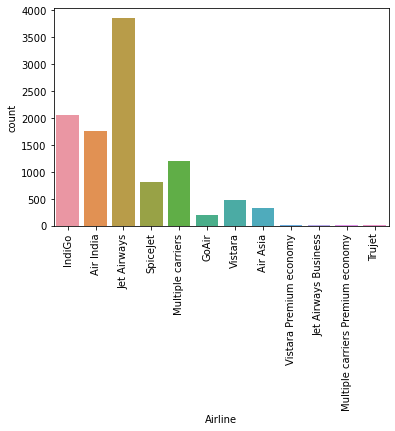

In [56]:
sns.countplot(x='Airline', data=df)
plt.xticks(rotation=90)

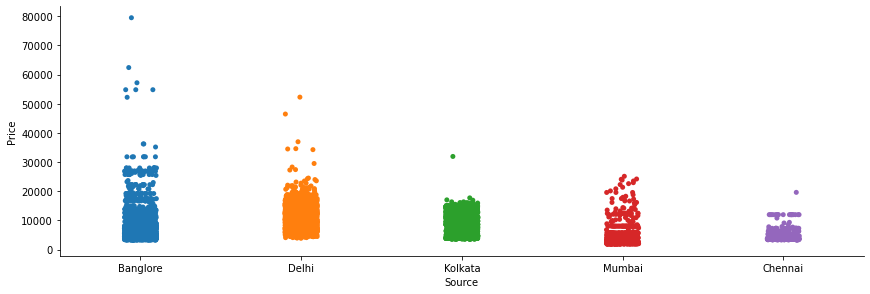

In [58]:
sns.catplot(y="Price",x="Source",data=df.sort_values("Price",ascending=False),height=4,aspect=3)

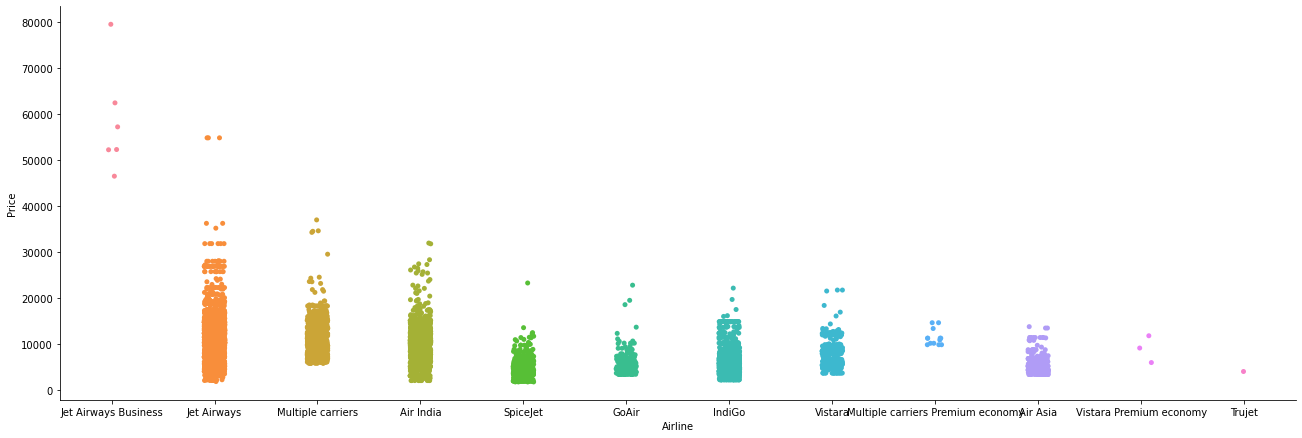

In [59]:
sns.catplot(y="Price",x="Airline",data=df.sort_values("Price",ascending=False),height=6,aspect=3)
plt.show()

In [60]:
df.Source.value_counts()/df.shape[0]

Delhi       0.424693
Kolkata     0.268745
Banglore    0.205654
Mumbai      0.065244
Chennai     0.035664
Name: Source, dtype: float64

In [61]:
df.Destination.value_counts()/df.shape[0]

Cochin       0.424693
Banglore     0.268745
Delhi        0.118412
New Delhi    0.087241
Hyderabad    0.065244
Kolkata      0.035664
Name: Destination, dtype: float64

In [62]:
df.Airline.value_counts()/df.shape[0]

Jet Airways                          0.360292
IndiGo                               0.192174
Air India                            0.163999
Multiple carriers                    0.111954
SpiceJet                             0.076570
Vistara                              0.044838
Air Asia                             0.029861
GoAir                                0.018160
Multiple carriers Premium economy    0.001217
Jet Airways Business                 0.000562
Vistara Premium economy              0.000281
Trujet                               0.000094
Name: Airline, dtype: float64

In [67]:
df.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [68]:
# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time

# Extracting Hours
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour

# Extracting Minutes
df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
df.drop(["Dep_Time"], axis = 1, inplace = True)

In [69]:
df

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR - DEL,22-03-2022 01:10,2h 50m,non-stop,No info,3897,22,20
1,Air India,Kolkata,Banglore,CCU - IXR - BBI - BLR,13:15,7h 25m,2 stops,No info,7662,5,50
2,Jet Airways,Delhi,Cochin,DEL - LKO - BOM - COK,10-06-2022 04:25,19h,2 stops,No info,13882,9,25
3,IndiGo,Kolkata,Banglore,CCU - NAG - BLR,23:30,5h 25m,1 stop,No info,6218,18,5
4,IndiGo,Banglore,New Delhi,BLR - NAG - DEL,21:35,4h 45m,1 stop,No info,13302,16,50
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU - BLR,22:25,2h 30m,non-stop,No info,4107,19,55
10679,Air India,Kolkata,Banglore,CCU - BLR,23:20,2h 35m,non-stop,No info,4145,20,45
10680,Jet Airways,Banglore,Delhi,BLR - DEL,11:20,3h,non-stop,No info,7229,8,20
10681,Vistara,Banglore,New Delhi,BLR - DEL,14:10,2h 40m,non-stop,No info,12648,11,30


In [70]:
# Arrival time is when the plane arrives at the gate.
# Similar to Date_of_Journey we can extract values from Arrival_Time

# Extracting Hours
df["Arrival_hour"] = pd.to_datetime(df.Arrival_Time).dt.hour

# Extracting Minutes
df["Arrival_min"] = pd.to_datetime(df.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
df.drop(["Arrival_Time"], axis = 1, inplace = True)

In [71]:
df

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR - DEL,2h 50m,non-stop,No info,3897,22,20,1,10
1,Air India,Kolkata,Banglore,CCU - IXR - BBI - BLR,7h 25m,2 stops,No info,7662,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL - LKO - BOM - COK,19h,2 stops,No info,13882,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU - NAG - BLR,5h 25m,1 stop,No info,6218,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR - NAG - DEL,4h 45m,1 stop,No info,13302,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU - BLR,2h 30m,non-stop,No info,4107,19,55,22,25
10679,Air India,Kolkata,Banglore,CCU - BLR,2h 35m,non-stop,No info,4145,20,45,23,20
10680,Jet Airways,Banglore,Delhi,BLR - DEL,3h,non-stop,No info,7229,8,20,11,20
10681,Vistara,Banglore,New Delhi,BLR - DEL,2h 40m,non-stop,No info,12648,11,30,14,10


In [73]:
# Time taken by plane to reach destination is called Duration
# It is the differnce betwwen Departure Time and Arrival time

# Assigning and converting Duration column into list
duration = list(df["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour
            
duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))                    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))         # Extracts only minutes from duration

In [74]:
# Adding duration_hours and duration_mins list to train_data dataframe

df["Duration_hours"] = duration_hours
df["Duration_mins"] = duration_mins

In [75]:
df.drop(["Duration"], axis = 1, inplace = True)

# Handling Categorical Data

In [76]:
df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [77]:
Airline = df[["Airline"]]

Airline = pd.get_dummies(Airline, drop_first= True)

Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [78]:
# As Source is Nominal Categorical data we will perform OneHotEncoding

Source = df[["Source"]]

Source = pd.get_dummies(Source, drop_first= True)

Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [79]:
df["Destination"].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [80]:
Destination=df[['Destination']]
Destination=pd.get_dummies(Destination, drop_first=True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [82]:
# Route and Total_Stops are related to each other
df.drop(["Route", "Additional_Info"], axis=1,inplace=True)

In [83]:
# Here Values are assigned with corresponding keys
df.replace({"non-stop": 0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4},inplace=True)

In [84]:
# Concatenate dataframe --> train_data + Airline + Source + Destination
df1=pd.concat([df, Airline, Source, Destination], axis = 1)

In [85]:
df1

,Airline,Source,Destination,Total_Stops,Price,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,0,3897,22,20,1,10,2,...,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,2,7662,5,50,13,15,7,...,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,2,13882,9,25,4,25,19,...,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,1,6218,18,5,23,30,5,...,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,1,13302,16,50,21,35,4,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,0,4107,19,55,22,25,2,...,0,0,0,1,0,0,0,0,0,0
10679,Air India,Kolkata,Banglore,0,4145,20,45,23,20,2,...,0,0,0,1,0,0,0,0,0,0
10680,Jet Airways,Banglore,Delhi,0,7229,8,20,11,20,3,...,0,0,0,0,0,0,1,0,0,0
10681,Vistara,Banglore,New Delhi,0,12648,11,30,14,10,2,...,0,0,0,0,0,0,0,0,0,1


In [86]:
df1.drop(["Airline", "Source", "Destination"],axis = 1,inplace=True)

In [87]:
df1.shape


(10683, 28)

In [89]:
X=df1.drop(['Price'], axis = 1)
X.head()

,Total_Stops,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,22,20,1,10,2,50,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,5,50,13,15,7,25,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2,9,25,4,25,19,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,18,5,23,30,5,25,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,1,16,50,21,35,4,45,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [90]:
y = df.Price

In [91]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

Performing Linear Regression

In [92]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 100 )

In [94]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [98]:
m1 = sm.OLS(y_train,X_train).fit()

In [99]:
ypred = m1.predict(X_test)

In [100]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test,ypred)
r_squared = r2_score(y_test,ypred)

In [101]:
from math import sqrt
rsme = sqrt(mse)
rsme

2818.623767024458

In [102]:
print('Mean_Squared_Error:', mse)
print('Root_Mean_Squared_Error:', rsme)
print('r_squared_value:', r_squared)

Mean_Squared_Error: 7944639.940035147
Root_Mean_Squared_Error: 2818.623767024458
r_squared_value: 0.6200430559667731


In [103]:
# K- Fold Cross Validation.
folds = 5
cv_mse = []
x = X_train.values
y = y_train.values
from sklearn.model_selection import KFold
kf = KFold(folds)
kf.get_n_splits(x)

for train_index, test_index in kf.split(x):
    print('train = ', train_index)
    print('test = ', test_index)
    print("\n")
    
for train_index , test_index in kf.split(x):
    cv_trainx , cv_testx = x[train_index], x[test_index]
    cv_trainy , cv_testy = y[train_index] , y[test_index]
    #Build the mdoel
    m = sm.OLS(cv_trainy, cv_trainx).fit()
    p = m.predict(cv_testx)
    #store the mse in the list of each model
    cv_mse.append(np.round(mean_squared_error(cv_testy, p),3))

train =  [1496 1497 1498 ... 7475 7476 7477]
test =  [   0    1    2 ... 1493 1494 1495]


train =  [   0    1    2 ... 7475 7476 7477]
test =  [1496 1497 1498 ... 2989 2990 2991]


train =  [   0    1    2 ... 7475 7476 7477]
test =  [2992 2993 2994 ... 4485 4486 4487]


train =  [   0    1    2 ... 7475 7476 7477]
test =  [4488 4489 4490 ... 5980 5981 5982]


train =  [   0    1    2 ... 5980 5981 5982]
test =  [5983 5984 5985 ... 7475 7476 7477]




In [104]:
cv_mse

[9078156.876, 8683243.895, 9187615.493, 9832381.875, 7670801.772]

In [105]:
#Mean MSE Of K-fold CV
np.mean(cv_mse)

8890439.9822

In [106]:
#RSME
rsme_tr=(sqrt(np.mean(cv_mse)))
rsme_tr

2981.6840849090636

In [108]:
#Predict on the test data
p1 = m1.predict(X_test)

In [110]:
pd.DataFrame({"y_pred":ypred,"P1":p1})

,y_pred,P1
7046,14233.813682,14233.813682
7401,7683.699145,7683.699145
6180,11572.740449,11572.740449
5798,11454.568784,11454.568784
7180,11579.733307,11579.733307
...,...,...
8235,11356.632455,11356.632455
2216,7092.276598,7092.276598
5328,11495.620121,11495.620121
5664,9140.225323,9140.225323


In [109]:
# MSE of model 1
mse1 = round(mean_squared_error(y_test,p1),3)

In [111]:
mse1

7944639.94

In [112]:
#rsme of testing
rsme_ts = sqrt(mse1)
rsme_ts

2818.6237670182236

In [113]:
# compare the train and test errors
print("Training MSE = {}, Testing MSE = {}".format(rsme_tr,rsme_ts))

Training MSE = 2981.6840849090636, Testing MSE = 2818.6237670182236


In [114]:
# compare the train and test errors
print("Training MSE = {}, Testing MSE = {}".format(np.mean(cv_mse),mse1))

Training MSE = 8890439.9822, Testing MSE = 7944639.94


In [116]:
# store the actual and predicted data for comparison
df = pd.DataFrame({'actual':y_test,'predicted':round(p1,3)})
df.head()

,actual,predicted
7046,19225,14233.814
7401,12395,7683.699
6180,10907,11572.740
5798,14714,11454.569
7180,14714,11579.733


# Decesion Tree

In [117]:
#Import the Decesion Tree Regressor
from sklearn.tree import DecisionTreeRegressor
m2 = DecisionTreeRegressor(random_state=100)

#Fit the Regressor
ds_dt = m2.fit(X_train,y_train)

In [118]:
y_pred_dt = m2.predict(X_test)

#Model Evaluation using R2 for Decision Tree Regressor
from sklearn import metrics
r_sq = metrics.r2_score(y_test,y_pred_dt)
print("R_Sq associated with Decision tree regressor is:",r_sq )

R_Sq associated with Decision tree regressor is: 0.5796665216771614


In [119]:
from sklearn.metrics import mean_absolute_error, r2_score

In [120]:
mae = mean_absolute_error(y_test,y_pred_dt)
mae

1734.0229721518053

In [121]:
mse_dt = mean_squared_error(y_test,y_pred_dt)
mse_dt

8788885.6683864

In [122]:
rmse_dt = sqrt(mse_dt)
rmse_dt

2964.6054827559096

# Hypertuning 

In [123]:
from sklearn.model_selection import RandomizedSearchCV

In [124]:
from sklearn.tree import DecisionTreeRegressor

parameter_space = \
    {
        "criterion": ["mse", "friedman_mse", "mae"],
        "min_samples_split": [5, 18, 29, 50],
        "min_samples_leaf": [3, 7, 15, 25],
        "max_features": [20, 50, 150, 200, X_train.shape[1]],
    }

clf = RandomizedSearchCV(DecisionTreeRegressor(random_state=3), parameter_space, 
                   cv=3, scoring="neg_mean_absolute_error", n_jobs=4)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 20, 'criterion': 'friedman_mse'}


In [125]:
dt_model = DecisionTreeRegressor(**clf.best_params_)
dt_model.fit(X_train, y_train)
dt_ypred = dt_model.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_ypred)
dt_rmse = sqrt(dt_mse)
print('Mean_Squared_Error:',dt_mse)
print('Root_Mean_Squared_Error',dt_rmse)

Mean_Squared_Error: 7678579.757999319
Root_Mean_Squared_Error 2771.025037418341


# Random Forest Regressor

In [126]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)

In [127]:
r_sq_rf = metrics.r2_score(y_test,y_pred_rf)
print("R_Sq associated with Decision tree regressor is:",r_sq_rf )

R_Sq associated with Decision tree regressor is: 0.637939787749886


In [128]:
mse_rf = mean_squared_error(y_test,y_pred_rf)
rmse_rf = sqrt(mse_rf)

In [129]:
print('Mean_Squared_Error:', mse_rf)
print('Root_Mean_Squared_Error:', rmse_rf)

Mean_Squared_Error: 7570431.513651493
Root_Mean_Squared_Error: 2751.441715474179


# Hypertuning

In [130]:
X_train.shape

(7478, 28)

In [131]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to be considered at every split
max_features = ['auto','srqt']
# Max number of levels in tree
max_depth = [2,4]
# Minimum number of samples required in node split
min_samples_split = [2,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2]
# Method of selecting samples for training each tree
bootstrap = [True,False]

In [132]:
# Create a parm grid
param_grid = {'n_estimators': n_estimators,
             'max_features': max_features,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf,
             'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'srqt'], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [133]:
rf_ran_cv = RandomizedSearchCV(estimator=rf,param_distributions=param_grid, cv =10 , verbose = 2, n_jobs=4)

In [134]:
rf_ran_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['auto', 'srqt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [135]:
rf_ran_cv.best_params_

{'n_estimators': 25,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'bootstrap': True}

In [136]:
rf_model = RandomForestRegressor(**rf_ran_cv.best_params_)
rf_model.fit(X_train, y_train)
rf_ypred = dt_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_ypred)
rf_rmse = sqrt(rf_mse)
print('Mean_Squared_Error:',rf_mse)
print('Root_Mean_Squared_Error',rf_rmse)

Mean_Squared_Error: 7678579.757999319
Root_Mean_Squared_Error 2771.025037418341


In [137]:
print(f'Train Accuracy - : {rf_model.score(X_train,y_train):.3f}')
print(f'Test Accuracy - : {rf_model.score(X_test,y_test):.3f}')

Train Accuracy - : 0.778
Test Accuracy - : 0.656
